# R Aquilae
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import torch

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants
from ipywidgets           import interact

from pomme.utils       import convert_angular_to_spatial
from pomme.plot        import plot_cube_2D, plot_spectrum
from pomme.object      import AstroObject
from pomme.observation import DataCube

from pomme.model       import TensorModel, SphericallySymmetric
from pomme.utils       import print_var, interpolate, convert_angular_to_spatial
from pomme.lines       import Line
from pomme.loss        import Loss, fourier_loss_1D, fourier_loss_1D

In [2]:
obj = AstroObject('R Aql')

Using the parallax distance.


In [3]:
# file = '/STER/hydroModels/jolienm/RAqlObservations/RAql-observations/ALMA_analysis/data/R_Aql/R_Aql_combined111_line_t0.15_spw2_CO.fits'
# dat  = DataCube(file)

In [4]:
# dat.img     = np.nan_to_num(dat.img, nan=0.0)
# dat.img_min = dat.img.min()
# dat.img_max = dat.img.max()

In [5]:
# dat.plot_channel_maps()

In [6]:
# dat.plot_spectrum()

In [7]:
# fi_min, fi_max =    6,   35
# xi_min, xi_max = 2500, 5700
# yi_min, yi_max = 2500, 5700

# obs       = dat.img[fi_min:fi_max, xi_min:xi_max, yi_min:yi_max].astype(np.float64)
# obs_freqs = dat.fs [fi_min:fi_max]
# obs_xlims = dat.xs [xi_max] - dat.xs[xi_min]
# obs_ylims = dat.xs [xi_max] - dat.xs[xi_min]

In [8]:
name = 'R_Aql'

In [9]:
# np.save(f'{name}_obs.npy',       obs.astype(np.float32))
# np.save(f'{name}_obs_freqs.npy', obs_freqs.value)
# np.save(f'{name}_obs_xlims.npy', obs_xlims.value)
# np.save(f'{name}_obs_ylims.npy', obs_ylims.value)

In [10]:
obs       = np.load(f'{name}_obs.npy').astype(np.float64)
obs_freqs = np.load(f'{name}_obs_freqs.npy') * units.Hz
obs_xlims = np.load(f'{name}_obs_xlims.npy') * units.deg
obs_ylims = np.load(f'{name}_obs_ylims.npy') * units.deg

In [11]:
# Normalise observations to max 1.0
obs *= (1.0/obs.max())

In [12]:
s_x = abs(convert_angular_to_spatial(obs_xlims, obj.distance)).si.value
s_y = abs(convert_angular_to_spatial(obs_ylims, obj.distance)).si.value
s_z = np.mean([s_x, s_y])

In [13]:
vmin = obs.min()
vmax = obs.max()

# Define a plot function
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs[f,:,:], vmin=obs.min(), vmax=obs.max())
            
interact(plot, f=(0, obs.shape[0]-1))

interactive(children=(IntSlider(value=14, description='f', max=28), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [14]:
spatial_average = obs.sum(axis=(1,2))
line_centre     = obs_freqs[np.where(spatial_average==spatial_average.max())[0][0]]

In [15]:
line = Line('CO', 1)

You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [16]:
v_los = abs(line.freq_to_velo(line_centre))
v_los

<Quantity 46328.79352163>

In [17]:
v_max = max(abs(line.freq_to_velo(obs_freqs) - line.freq_to_velo(line_centre))).value
v_max

19049.04747816665

In [18]:
o = obs.T
# fqs = freqs

def half_resolution(x):
    return 0.25*(x[0::2,0::2,:] + x[0::2,1::2,:] + x[1::2,0::2,:] + x[1::2,1::2,:])

# Create a list of hiearchically reduced observations
o_list = [o]
while o.shape[0]/2 >= 100:
    o = half_resolution(o)
    o_list.append(o)

for i, o in enumerate(o_list):
    print(f'o_list[{i}].shape =', list(o.shape))

o_list[0].shape = [3200, 3200, 29]
o_list[1].shape = [1600, 1600, 29]
o_list[2].shape = [800, 800, 29]
o_list[3].shape = [400, 400, 29]
o_list[4].shape = [200, 200, 29]
o_list[5].shape = [100, 100, 29]


In [19]:
obs = o

vmin = obs.min()
vmax = obs.max()

# Define a plot function
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs[:,:,f], vmin=vmin, vmax=vmax)
            
interact(plot, f=(0, obs.shape[2]-1))

interactive(children=(IntSlider(value=14, description='f', max=28), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [20]:
obs = o_list[-1]

# Define a plot function
ymin = obs.min()
ymax = obs.max()

def plot(i,j):
    plt.figure(dpi=150)
    plt.step(obs_freqs, obs[i,j,:])
    plt.ylim((ymin, ymax))
    plt.axvline(line_centre.value, c='k')

# Return an interactive ipywidget
interact(
    plot,
    i=(0, obs.shape[0]-1),
    j=(0, obs.shape[1]-1)
)

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [21]:
obs = torch.from_numpy(o_list[-1])
sizes = (s_x, s_y, s_z)
shape = (obs.shape[0], obs.shape[1], 128)
freqs = torch.from_numpy(obs_freqs.si.value)
# freqs = torch.linspace(freqs.min(), freqs.max(), 100)

print('shape =', shape)

shape = (100, 100, 128)


In [22]:
# freqs = line.frequency * (1.0 + 4.0e+3/constants.c.si.value * torch.linspace(-1, +1, 100))

In [23]:
model = TensorModel(
    sizes = np.array(sizes),
    shape = shape,
)

r_x, r_y, r_z = model.get_radial_direction(origin='centre')
r             = model.get_radius          (origin='centre')
inverse_r     = r.min() / r

model['log_M'           ] = np.array([np.log(constants.M_sun.si.value)])
model['log_CO'          ] = np.log(1.0e+11 * inverse_r**2)
model['log_temperature' ] = np.log(5.0e+3  * inverse_r)
# model['log_CO'          ] = np.log(1.0e+10) * np.ones(model.shape)
# model['log_temperature' ] = np.log(5.0e+2 ) * np.ones(model.shape)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)
model['velocity_x'      ] = 0.5e+0 * r_x
model['velocity_y'      ] = 0.5e+0 * r_y
model['velocity_z'      ] = 0.5e+0 * r_z
model['log_v_los'       ] = np.array([np.log(v_los.si.value)])
# model['log_distance']

# loss = Loss(['reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
# loss = Loss(['rep', 'reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
loss = Loss(['rep', 'reg', 'sym', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])

model.free_all()
model.fix('log_v_turbulence')
model.fix('log_v_los')

model.info()


Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_M                      Free          False    +6.976e+01     +6.976e+01     +6.976e+01
  log_CO                     Free          True     +1.600e+01     +1.727e+01     +2.533e+01
  log_temperature            Free          True     +3.852e+00     +4.486e+00     +8.517e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  velocity_x                 Free          True     -5.000e-01     +0.000e+00     +5.000e-01
  velocity_y                 Free          True     -5.000e-01     -7.105e-19     +5.000e-01
  velocity_z                 Free          True     -4.999e-01     +3.109e-19     +4.999e-01
  log_v_los                  Fixed         False    +1.074e+01     +1.074e+01     +1.074e+01
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 128)


In [24]:
def forward(model, freqs):
    """
    Forward model: image the given TensorModel along the last axis at the given frequencies.
    """
    return line.LTE_image_along_last_axis(
        density      = torch.exp(model['log_CO']),
        temperature  = torch.exp(model['log_temperature']),
        v_turbulence = torch.exp(model['log_v_turbulence']),
        velocity_los = torch.exp(model['log_v_los']) + v_max * model['velocity_z'],
        frequencies  = freqs,
        dx           = model.dx(model.dim()-1)
    )

In [25]:
img  = forward (model, freqs)

def plot_spectrum():
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.plot(line.freq_to_velo(freqs * units.Hz), obs [i,j,:].data)
        plt.plot(line.freq_to_velo(freqs * units.Hz), img [i,j,:].data * 1.0e+14, marker='x')
        # plt.ylim((1.0e-30, 1.0e+1))
        # plt.yscale('log')
        # plt.axvline(vel(line.frequency)-v_los.si.value, c='k')
        # plt.axvline(vel(line.frequency), c='k')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, img.shape[0]-1),
                    j=(0, img.shape[1]-1) )

plot_spectrum()

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [26]:
print_var('img', img)

img -4.85e-29 +4.23e-16 +1.21e-14


In [27]:
torch.sum(img < 0)

tensor(75148)

In [28]:
gamma = 1.2
mu    = 2.381 * constants.u.si.value

def steady_state_hydrodynamic_loss(model, f_x=0.0, f_y=0.0, f_z=0.0, heating_m_cooling=0.0):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """

    r = model.get_coords(origin='centre')
    d = torch.from_numpy(r / np.linalg.norm(r, axis=0)**3)
    
    log_rho = model['log_CO']
    log_tmp = model['log_temperature'] 
    log_M   = model['log_M']

    rho = torch.exp(log_rho)         
    tmp = torch.exp(log_tmp)
    M   = torch.exp(log_M)
    
    v_x = v_max * model['velocity_x']
    v_y = v_max * model['velocity_y']
    v_z = v_max * model['velocity_z']

    kBT_o_mu = (constants.k_B.si.value / mu) * tmp

    # Energy    
    eng = 0.5 * (v_x**2 + v_y**2 + v_z**2) + (gamma / (gamma - 1.0)) * kBT_o_mu

    # log rho + log T
    log_rho_p_log_tmp = log_rho + log_tmp
    
    f_x = -constants.G.si.value * M * d[0]
    f_y = -constants.G.si.value * M * d[1]
    f_x = -constants.G.si.value * M * d[2]

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = model.diff_x(rho * v_x) + model.diff_y(rho * v_y) + model.diff_z(rho * v_z)

    # Momentum equation (steady state): v . grad(v) + grad(P) / rho = f
    loss_momx = v_x * model.diff_x(v_x) + v_y * model.diff_y(v_x) + v_z * model.diff_z(v_x) + kBT_o_mu * model.diff_x(log_rho_p_log_tmp) - f_x
    loss_momy = v_x * model.diff_x(v_y) + v_y * model.diff_y(v_y) + v_z * model.diff_z(v_y) + kBT_o_mu * model.diff_y(log_rho_p_log_tmp) - f_y
    loss_momz = v_x * model.diff_x(v_z) + v_y * model.diff_y(v_z) + v_z * model.diff_z(v_z) + kBT_o_mu * model.diff_z(log_rho_p_log_tmp) - f_z

    # Energy equation (steady state): div(u v) - Lambda = 0
    loss_engy = rho * (model.diff_x(eng) * v_x + model.diff_y(eng) * v_y + model.diff_z(eng) * v_z) - heating_m_cooling

    # Compute the mean squared losses
    losses = torch.stack([
        ((loss_cont/     rho )**2).mean(),
        ((loss_momx/     v_x )**2).mean(),
        ((loss_momy/     v_y )**2).mean(),
        ((loss_momz/     v_z )**2).mean(),
        ((loss_engy/(rho*eng))**2).mean()
    ])

    # Return losses
    return losses


def z_pos_symmetry_loss(arr):
    return torch.mean((arr - torch.flip(arr, dims=(2,)))**2)


def z_neg_symmetry_loss(arr):
    return torch.mean((arr + torch.flip(arr, dims=(2,)))**2)

In [29]:
from pomme.loss import SphericalLoss

spherical_loss = SphericalLoss(model, origin='centre')    

In [30]:
w_rep = 1.0 / nn.functional.mse_loss(forward(model,freqs), obs).item()
w_reg = 1.0 / model.apply_to_fields(diff_loss).item()

L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)

w_con = 1.0 / L_con.item()
w_mom = 1.0 / torch.stack([L_mom_x, L_mom_y, L_mom_z]).mean().item()
w_eng = 1.0 / L_eng.item()

In [31]:
keys = ['velocity_z', 'log_CO', 'log_temperature']

def plot_along_z_axis(model, keys):
    n_plots = len(keys)

    def plot(i,j):
        fig, axs = plt.subplots(n_plots, figsize=(5, 3*n_plots), dpi=150)
        for n, key in enumerate(keys):
            axs[n].plot(model[key][i,j,:].data, label=key)
            axs[n].legend()

    return interact(plot, 
               i=(0, model.shape[0]-1),
               j=(0, model.shape[1]-1)
           )

plot_along_z_axis(model, keys)

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot_along_z_axis.<locals>.plot(i, j)>

In [32]:
v_max

19049.04747816665

In [33]:
plot_cube_2D(img)

interactive(children=(IntSlider(value=14, description='z', max=28), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

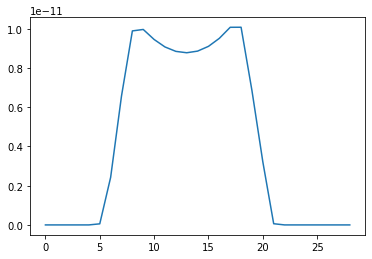

In [34]:
plt.plot(img.sum(axis=(0,1)).data)

In [35]:
def fit(loss, model, obs, N_epochs=10, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_sym=1.0, w_con=1.0, w_mom=1.0, w_eng=1.0):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = torch.abs(forward(model, freqs))
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * nn.functional.mse_loss(img*1.0e+14, obs)

        # Symmetry loss
        # loss['sym'] = w_sym * (torch.zeros(1)                \
        #     + z_pos_symmetry_loss(model['log_CO'          ]) \
        #     + z_pos_symmetry_loss(model['log_temperature' ]) \
        #     + z_pos_symmetry_loss(model['log_v_turbulence']) \
        #     + z_pos_symmetry_loss(model['velocity_x'      ]) \
        #     + z_pos_symmetry_loss(model['velocity_y'      ]) \
        #     + z_neg_symmetry_loss(model['velocity_z'      ]) )

        # Compute the regularisation loss
        loss['reg'] = w_reg * model.apply_to_fields(diff_loss)
        loss['sym'] = w_sym * model.apply_to_fields(
            func    = spherical_loss.eval,
            exclude = ['velocity_x', 'velocity_y', 'velocity_z'],
            include = [model['velocity_x']**2 + model['velocity_y']**2 + model['velocity_z']**2]
        )

        L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)
    
        loss['hyd_con' ] = w_con * L_con
        loss['hyd_momx'] = w_mom * L_mom_x
        loss['hyd_momy'] = w_mom * L_mom_y
        loss['hyd_momz'] = w_mom * L_mom_z
        loss['hyd_eng' ] = w_eng * L_eng

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

In [36]:
fit(loss, model, obs, N_epochs=1, lr=1.0e-1)

  0%|          | 0/1 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1/1 [00:10<00:00, 10.73s/it]


In [37]:
loss.renormalise_all()

100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


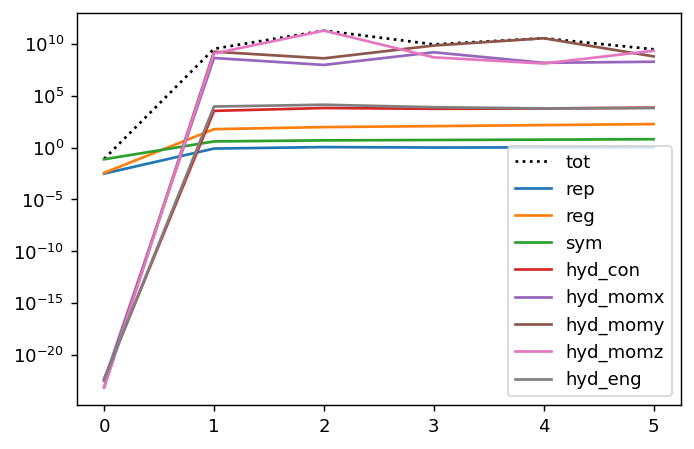

In [38]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [39]:
loss.renormalise_all()

100%|██████████| 5/5 [00:57<00:00, 11.41s/it]


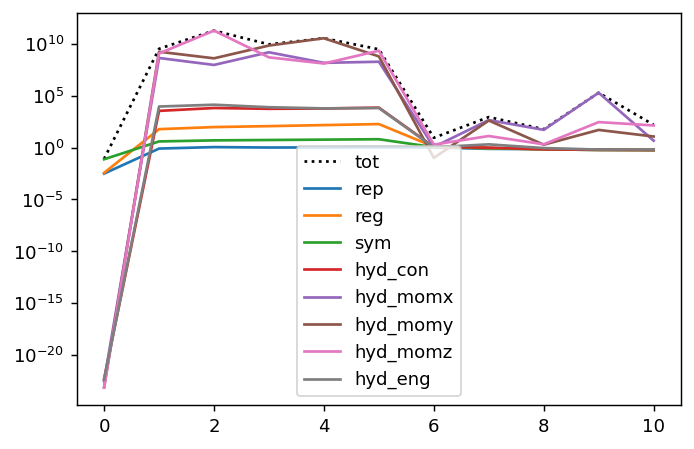

In [40]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [41]:
loss.renormalise_all()

100%|██████████| 100/100 [19:00<00:00, 11.40s/it]


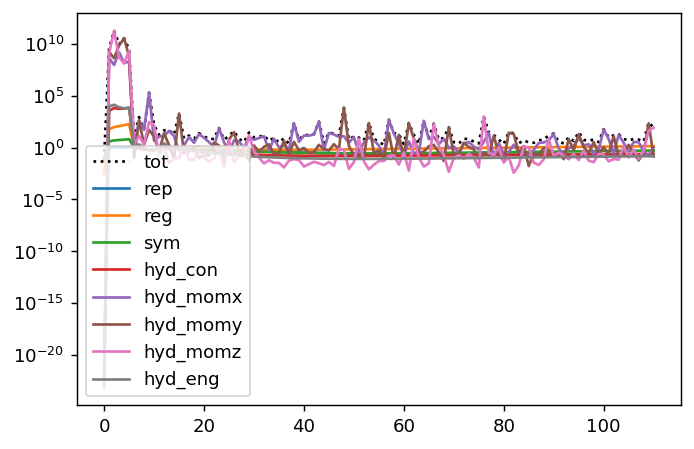

In [42]:
fit(loss, model, obs, N_epochs=100, lr=1.0e-1)
loss.plot()

In [47]:
w_rep = 1.0 /  loss['rep'     ].item()
w_reg = 1.0 /  loss['reg'     ].item()
w_sym = 1.0 /  loss['sym'     ].item()
w_con = 1.0 /  loss['hyd_con' ].item()
w_mom = 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng = 1.0 /  loss['hyd_eng' ].item()

100%|██████████| 5/5 [00:48<00:00,  9.79s/it]


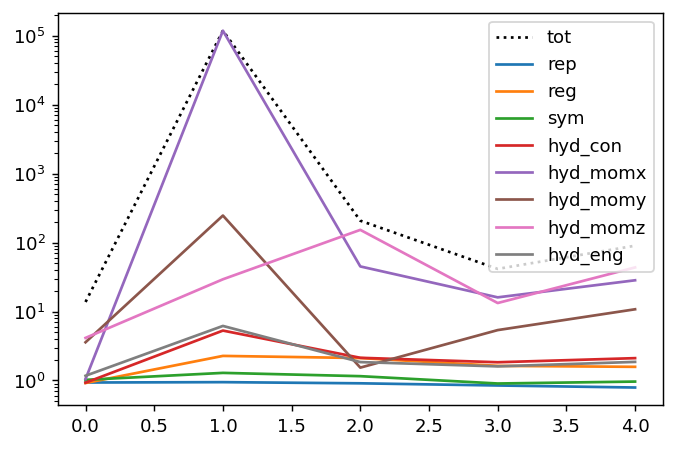

In [49]:
fit(loss, model, obs,
    N_epochs = 5,
    lr       = 1.0e-1,
    w_rep    = w_rep,
    w_reg    = w_reg,
    w_sym    = w_sym,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

In [50]:
w_rep *= 1.0 /  loss['rep'     ].item()
w_reg *= 1.0 /  loss['reg'     ].item()
w_sym *= 1.0 /  loss['sym'     ].item()
w_con *= 1.0 /  loss['hyd_con' ].item()
w_mom *= 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng *= 1.0 /  loss['hyd_eng' ].item()

In [51]:
loss.__init__(keys=loss.loss.keys())

100%|██████████| 250/250 [44:14<00:00, 10.62s/it]


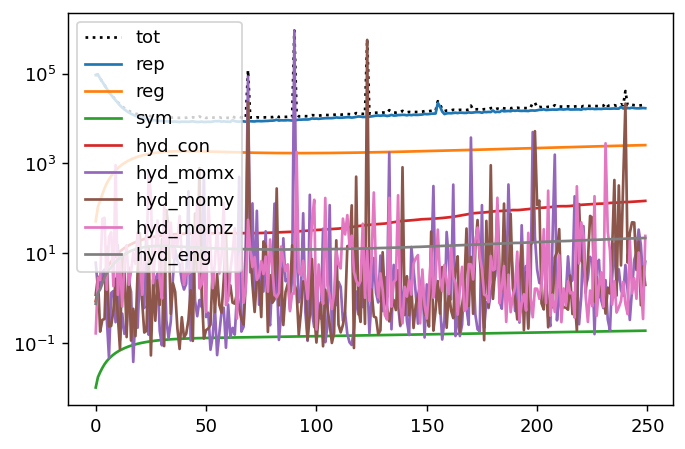

In [52]:
fit(loss, model, obs,
    N_epochs = 250,
    lr       = 1.0e-1,
    w_rep    = 1.0e+5*w_rep,
    w_reg    = 5.0e+1*w_reg,
    w_sym    = 1.0e-2*w_sym,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

In [53]:
model.save('r_aql_test_after_250.h5')

In [54]:
plot_along_z_axis(model, keys)

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot_along_z_axis.<locals>.plot(i, j)>

In [ ]:
loss.__init__(keys=loss.loss.keys())

In [ ]:
fit(loss, model, obs,
    N_epochs = 250,
    lr       = 2.0e-2,
    w_rep    = w_rep,
    w_reg    = w_reg,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

  9%|▉         | 22/250 [00:47<08:03,  2.12s/it]

In [ ]:
img = forward(model, freqs)

velos = (freqs / line.frequency - 1.0) * constants.c.si.value

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('Observations')
    plt.plot(velos, 1.0e+14*img[i,j,:].data, label='img')
    plt.plot(velos, obs[i,j,:].data, label='obs')
    # plt.ylim((1.0e-30, 1.0e+1))
    # plt.yscale('log')
    # plt.axvline(line.frequency, c='k')
    plt.legend()

interact(plot, 
    i=(0, img.shape[0]-1),
    j=(0, img.shape[1]-1)
)


interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [ ]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=99, description='z', max=199), Output()), _dom_classes=('widget-interact…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
# dat = torch.exp(model['log_v_los']) - model['velocity_z']
key = 'log_CO'
dat = model[key]

def plot(i,j):
    plt.figure(dpi=150)
    plt.title(key)
    plt.plot(dat[i,j,:].data)

interact(plot, 
    i=(0, dat.shape[0]-1),
    j=(0, dat.shape[1]-1)
)

interactive(children=(IntSlider(value=99, description='i', max=199), IntSlider(value=99, description='j', max=…

<function __main__.plot(i, j)>

In [ ]:
plot_cube_2D(model['log_temperature'].T)

/tmp/ipykernel_865196/3154095005.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plot_cube_2D(model['log_temperature'].T)


interactive(children=(IntSlider(value=99, description='z', max=199), Output()), _dom_classes=('widget-interact…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
# dat = torch.exp(model['log_v_los']) - model['velocity_z']
key = 'log_temperature'
dat = model[key]

def plot(i,j):
    plt.figure(dpi=150)
    plt.title(key)
    plt.plot(dat[i,j,:].data)

interact(plot, 
    i=(0, dat.shape[0]-1),
    j=(0, dat.shape[1]-1)
)

interactive(children=(IntSlider(value=99, description='i', max=199), IntSlider(value=99, description='j', max=…

<function __main__.plot(i, j)>

In [ ]:
dat =  model['velocity_z']

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('velocity')
    plt.plot(dat[i,j,:].data)

interact(plot, 
    i=(0, dat.shape[0]-1),
    j=(0, dat.shape[1]-1)
)

interactive(children=(IntSlider(value=4, description='i', max=9), IntSlider(value=4, description='j', max=9), …

<function __main__.plot(i, j)>

In [ ]:
plot_cube_2D(torch.abs(torch.exp(model['log_v_los']-model['velocity_z'].T)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
img = forward(model, freqs)

velos = (freqs / line.frequency - 1.0) * constants.c.si.value

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('Observations')
    plt.plot(velos, 1.0e+14*img[i,j,:].data, label='img')
    plt.plot(velos,         obs[i,j,:].data, label='obs')
    # plt.ylim((1.0e-30, 1.0e+1))
    # plt.yscale('log')
    # plt.axvline(line.frequency, c='k')
    plt.legend()

interact(plot, 
    i=(0, img.shape[0]-1),
    j=(0, img.shape[1]-1)
)


interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [ ]:
plot_cube_2D(img)

interactive(children=(IntSlider(value=14, description='z', max=28), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_M                      Free          False    +6.973e+01     +6.973e+01     +6.973e+01
  log_CO                     Free          True     +1.882e+01     +2.005e+01     +2.773e+01
  log_temperature            Free          True     +4.480e+00     +7.104e+00     +9.446e+00
  log_v_turbulence           Free          True     +4.428e+00     +4.922e+00     +7.957e+00
  velocity_x                 Free          True     -1.185e+00     +9.266e-04     +1.061e+00
  velocity_y                 Free          True     -1.206e+00     +2.678e-03     +1.270e+00
  velocity_z                 Free          True     -1.632e+00     +1.546e-02     +1.030e+00
  log_v_los                  Free          False    +1.036e+01     +1.036e+01     +1.036e+01
sizes: (559518906748033.94, 559518906748033.94, 559518906748033.94)
shape: (100, 100, 100)
